# Treinamento do modelo

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [3]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_forecasting import TimeSeriesDataSet, RecurrentNetwork
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE, MAPE
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger


from src.treinamento_modelo import (
    expanding_window_split,
    plotar_previsao,
    previsao_naive,
    previsao_snaive,
    calcular_wmae_wmape,
    previsao_prophet,
    modelagem_lstm,
    previsao_lstm,
    previsao_tft
)

warnings.filterwarnings("ignore")

# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [ ]:
# Carregando os dados processados
df_sales_processed = pd.read_parquet("../data/processed/sales_cleaning_processed.parquet")

df_sales_processed.set_index("date", inplace=True)
df_sales_processed["series_id"] = (
    df_sales_processed["store_id"] + "_" + df_sales_processed["cat_id"]
)

In [9]:
# Verificando os dados
print(df_sales_processed.head())


           store_id cat_id    sales  in_training
date                                            
2011-01-29     CA_1  FOODS  7240.65         True
2011-01-30     CA_1  FOODS  6705.51         True
2011-01-31     CA_1  FOODS  4584.85         True
2011-02-01     CA_1  FOODS  4965.46         True
2011-02-02     CA_1  FOODS  4368.07         True


A partir deste ponto, criaremos os modelos para a previsão no varejo. Inicialmente, construiremos um modelo base simples que servirá como benchmark para comparação com modelos mais complexos.

Como ainda não sabemos qual algoritmo será mais adequado para os nossos dados, adotaremos uma abordagem exploratória. Primeiramente, testaremos diversos modelos de machine learning e deep learning utilizando seus hiperparâmetros padrão, a menos que ajustes sejam estritamente necessários.

Após essa análise preliminar de desempenho, selecionaremos o modelo mais promissor e, então, aplicaremos técnicas de otimização para aprimorá-lo. Dessa forma, criaremos dois modelos: um baseline, que servirá como referência, e outro refinado, ajustado a partir dos insights obtidos na primeira etapa de experimentação.

## Modelo de Base

In [ ]:
# Método Naive para a primeira divisão de CV
training_df, _, test_df = expanding_window_split(df_sales_processed, 0, validation=False)
naive_test_df = previsao_naive(training_df, test_df)
naive_test_df.info()
naive_test_df.head(3)

Agora vamos plotar as previsões.

In [ ]:
# Plotando a previsão
plotar_previsao(naive_test_df, "TX_2_FOODS", "naive_pred")

A partir do nosso gráfico, podemos observar que as previsões do método **Naïve** são pouco informativas, pois resultam em uma linha horizontal constante. Isso era esperado, já que se trata de um modelo ingênuo.

Agora, vamos implementar o método **sNaïve**. Diferente do método **Naïve**, que simplesmente utiliza o último valor observado como previsão para todos os períodos futuros, o método **sNaïve** leva em conta a sazonalidade dos dados. No nosso caso, a previsão para um determinado dia será baseada no valor observado no mesmo dia da semana anterior, considerando um período sazonal de **7 dias**, conforme identificado na fase de exploração dos dados. Isso permite que o modelo capture padrões recorrentes dentro da série temporal, tornando-o um baseline mais robusto para séries com comportamento sazonal.

In [ ]:
# previsões sNaive para a primeira divisão de CV
training_df, _, test_df = expanding_window_split(df_sales_processed, 0, validation=False)
snaive_test_df = previsao_snaive(training_df, test_df)
snaive_test_df.info()
snaive_test_df.head(10)

Da mesma forma, vamos plotar as previsões do método **sNaïve** em comparação com as vendas reais para uma série temporal aleatória.

In [ ]:
plotar_previsao(snaive_test_df, "TX_2_FOODS", "snaive_pred")

Desta vez, as previsões do método **sNaïve** parecem muito mais realistas, conseguindo, de certa forma, acompanhar as oscilações das vendas reais.  

Sabemos, de forma intuitiva, que o método **sNaïve** é um baseline mais adequado do que o **Naïve**, pois consegue capturar padrões sazonais nos dados. No entanto, para avaliar seu desempenho de forma objetiva, podemos utilizar métricas como **MAE (Mean Absolute Error)** e **MAPE (Mean Absolute Percentage Error)**, que nos ajudam a quantificar a precisão das previsões.  

De acordo com o Prof. **Rob Hyndman**, em seu [artigo](https://robjhyndman.com/papers/foresight.pdf), existem quatro tipos principais de métricas para avaliação de previsões em séries temporais. No nosso caso, utilizaremos **MAE** e **MAPE** para cada série individualmente.  

Além disso, como estamos lidando com múltiplas séries temporais, precisamos calcular um escore geral ponderado que combine todas elas. Para isso, seguimos a abordagem adotada na [Competição M5 do Kaggle](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation), onde o peso de cada série é baseado no total de vendas em dólares das últimas **28 observações** do conjunto de treinamento. Essa ponderação garante que séries com maior impacto nas vendas tenham maior influência na métrica final, proporcionando uma avaliação mais representativa da performance do modelo.

In [ ]:
# Lista de métodos de previsão e seus respectivos nomes de coluna no DataFrame
metodos_previsao = [(previsao_naive, "naive_pred"), (previsao_snaive, "snaive_pred")]

cv = 3
resultados_naive = []

for metodo, nome_previsto in metodos_previsao:
    wmae_lista = []
    wmape_lista = []

    for i in range(cv):
        training_df, _, test_df = expanding_window_split(df_sales_processed, i, validation=False)
        test_df_previsto = metodo(training_df, test_df)  # Aplica o método de previsão
        wmae, wmape = calcular_wmae_wmape(training_df, test_df_previsto, "sales", nome_previsto)

        wmae_lista.append(wmae)
        wmape_lista.append(wmape)

    # Armazena os resultados em uma lista
    resultados_naive.append(
        {
            "Modelo": nome_previsto,
            "WMAE - Média CV": np.mean(wmae_lista),
            "WMAE - Desvio Padrão CV": np.std(wmae_lista),
            "WMAPE - Média CV": np.mean(wmape_lista),
            "WMAPE - Desvio Padrão CV": np.std(wmape_lista),
        }
    )

# Criando DataFrame com os resultados de ambos os métodos
df_resultados_naive = pd.DataFrame(resultados_naive)

# Exibir os resultados formatados
df_resultados_naive

Com base no WMAE (Erro Absoluto Médio Ponderado) calculado a partir da validação cruzada em três divisões, o método sNaïve apresenta um erro quase 50% menor em comparação com o método Naïve.

Da mesma forma, ao analisar o WMAPE (Erro Percentual Absoluto Médio Ponderado), observamos que o modelo sNaïve também supera o Naïve, confirmando sua melhor capacidade de capturar padrões sazonais nos dados.

Diante desses resultados, adotaremos o sNaïve como nosso baseline para as previsões.

## Prophet

O Prophet é um modelo desenvolvido pelo Facebook, especialmente projetado para a previsão de séries temporais com sazonalidades, tendências e eventos especiais. Ele se destaca por sua facilidade de uso, capacidade de capturar padrões complexos e robustez na presença de dados irregulares ou lacunas.

In [ ]:
# Executar modelo Prophet para a primeira divisão de CV
cv = 0
training_df, validation_df, test_df = expanding_window_split(df_sales_processed, cv, validation=True)
prophet_test_df = previsao_prophet(training_df, validation_df, cv)
prophet_test_df.info()
prophet_test_df.head(3)

In [ ]:
# plot Prophet predictions against actual sales
plotar_previsao(prophet_test_df, "TX_1_FOODS", "prophet_pred")

In [ ]:
# Lista de métodos de previsão e seus respectivos nomes de coluna no DataFrame
metodos_previsao = [(previsao_prophet, "prophet_pred")]

cv = 3
resultados_prophet = []

for metodo, nome_previsto in metodos_previsao:
    wmae_lista = []
    wmape_lista = []

    for i in range(cv):
        training_df, _, test_df = expanding_window_split(df_sales_processed, i, validation=False)
        test_df_previsto = metodo(training_df, test_df, 0)
        wmae, wmape = calcular_wmae_wmape(training_df, test_df_previsto, "sales", nome_previsto)

        wmae_lista.append(wmae)
        wmape_lista.append(wmape)

    # Armazena os resultados em uma lista
    resultados_prophet.append(
        {
            "Modelo": nome_previsto,
            "WMAE - Média CV": np.mean(wmae_lista),
            "WMAE - Desvio Padrão CV": np.std(wmae_lista),
            "WMAPE - Média CV": np.mean(wmape_lista),
            "WMAPE - Desvio Padrão CV": np.std(wmape_lista),
        }
    )

# Criando DataFrame com os resultados de ambos os métodos
df_resultados_prophet = pd.DataFrame(resultados_prophet)

# Exibir os resultados formatados
df_resultados_geral = pd.concat([df_resultados_naive, df_resultados_prophet])

Podemos observar que o **Prophet** apresentou um desempenho superior aos métodos de previsão **Naïve** e **sNaïve**. Esse resultado pode ser atribuído à sua capacidade de capturar tanto **sazonalidades** quanto **tendências** presentes nos dados, resultando em erros significativamente menores.  

Além disso, o **Prophet** é um modelo robusto e de fácil implementação, o que o torna uma excelente opção para previsões de séries temporais, especialmente quando há padrões complexos que os métodos ingênuos não conseguem captar adequadamente.  

Até o momento, esse modelo seria a melhor opção para realizarmos o **ajuste fino**, visando otimizar ainda mais as previsões. No entanto, também consideramos testar um modelo de **deep learning** para avaliar se conseguimos obter um desempenho ainda melhor.

## LSTM

O modelo **LSTM (Long Short-Term Memory)** é um tipo de rede neural recorrente (RNN) projetado para lidar com **dados sequenciais**, sendo amplamente utilizado em **séries temporais** devido à sua capacidade de capturar dependências de longo prazo. Diferente das RNNs tradicionais, o **LSTM** resolve o problema do **desvanecimento do gradiente**, permitindo que o modelo retenha informações relevantes ao longo do tempo.  

No contexto de séries temporais, o **LSTM** é capaz de identificar **padrões não lineares, tendências e sazonalidades**, tornando-se uma abordagem poderosa para previsões. Ele pode ser aplicado em diversas áreas, como previsão de demanda, detecção de anomalias e modelagem financeira, oferecendo uma alternativa robusta aos métodos estatísticos tradicionais.  

Neste projeto, exploramos o **LSTM** como uma solução avançada para melhorar a precisão das previsões, aproveitando sua capacidade de aprender padrões complexos nos dados e adaptar-se a variações dinâmicas ao longo do tempo.

In [ ]:
df_sales_processed_lstm = df_sales_processed.copy()
df_sales_processed_lstm.reset_index(inplace=True, drop=False)

In [ ]:
df_sales_processed_lstm["time_idx"] = (
    df_sales_processed_lstm["date"] - df_sales_processed_lstm["date"].min()
).dt.days
df_sales_processed_lstm.head(3)

In [ ]:
# Dividindo os dados em conjuntos de treinamento, validação e teste
training_df, validation_df, test_df = expanding_window_split(
    df_sales_processed_lstm, 1, validation=True
)

# Criando e configurando o modelo LSTM, juntamente com o treinador e os dataloaders
model, trainer, train_dataloader, val_dataloader, test_dataloader = modelagem_lstm(
    training_df, validation_df, test_df, max_epochs=20
)

# Treinando o modelo LSTM
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# Obtendo as previsões do modelo LSTM para o conjunto de teste
test_df_previsto = previsao_lstm(trainer, test_dataloader, test_df)

In [ ]:
# extrair previsões do melhor checkpoint do modelo
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RecurrentNetwork.load_from_checkpoint(best_model_path)

In [ ]:
# visualizar as previsões do nosso modelo
# com base na documentação do pytorch-forecasting, a saída de predict é uma tupla de previsão com os campos prediction, x, index, decoder_lengths, y
# https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.base_model.BaseModel.html#pytorch_forecasting.models.base_model.BaseModel.predict
raw_predictions, x, _, _, _ = best_model.predict(test_dataloader, mode="raw", return_x=True)

for idx in range(2):  # plotar 3 exemplos
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

In [ ]:
# computes the cross-validated weighted MAE and MAPE for a model
wmae_lista = []
wmape_lista = []
cv = 3
max_epochs = 20

resultados_lstm = []

nome_previsto = "lstm_pred"

for i in range(cv):
    training_df, validation_df, test_df = expanding_window_split(
        df_sales_processed_lstm, i, validation=True
    )
    model, trainer, train_dataloader, val_dataloader, test_dataloader = modelagem_lstm(
        training_df, validation_df, test_df, max_epochs=max_epochs
    )

    test_df_previsto = previsao_lstm(
        trainer, model, train_dataloader, val_dataloader, test_dataloader, test_df
    )

    wmae, wmape = calcular_wmae_wmape(training_df, test_df_previsto, "sales", nome_previsto)

    wmae_lista.append(wmae)
    wmape_lista.append(wmape)

# Armazena os resultados em uma lista
resultados_lstm.append(
    {
        "Modelo": nome_previsto,
        "WMAE - Média CV": np.mean(wmae_lista),
        "WMAE - Desvio Padrão CV": np.std(wmae_lista),
        "WMAPE - Média CV": np.mean(wmape_lista),
        "WMAPE - Desvio Padrão CV": np.std(wmape_lista),
    }
)

# Criando DataFrame com os resultados de ambos os métodos
df_resultados_lstm = pd.DataFrame(resultados_lstm)

# Exibir os resultados formatados
# df_resultados_geral = pd.concat([df_resultados_geral, df_resultados_lstm])

In [ ]:
df_resultados_lstm

O nosso modelo **LSTM** apresentou um melhor desempenho comparado ao método **Prophet**, demonstrando uma capacidade superior de capturar padrões complexos nos dados. Embora o **Prophet** tenha se saído melhor que os métodos **Naïve** e **sNaïve**, reduzindo significativamente os erros por conseguir modelar sazonalidades e tendências, o **LSTM** conseguiu superar esses resultados.  

Isso pode ser atribuído à capacidade das redes neurais recorrentes de aprender **padrões não lineares e dependências de longo prazo**, tornando-as mais eficazes em séries temporais mais complexas.  

Diante desse cenário, o **LSTM** se torna a melhor opção para seguirmos com o **ajuste fino**, buscando otimizar ainda mais seu desempenho. No entanto, seguimos explorando outras abordagens para garantir que estamos utilizando o modelo mais adequado ao nosso problema. Apesar do desempenho superior, ainda podemos testar mais um modelo chamado TFT.

## Temporal Fusion Transformer (TFT)

O **Temporal Fusion Transformer (TFT)** é um modelo de **deep learning** projetado para modelagem de séries temporais, sendo capaz de lidar tanto com **séries multivariadas** quanto com **séries univariadas**. Sua principal vantagem está na combinação de **atenção multi-head** e **redes LSTM**, permitindo capturar **relações complexas entre variáveis** e aprender **padrões temporais de curto e longo prazo** com alta precisão.  

Embora seja amplamente utilizado para **séries temporais multivariadas**, o **TFT** também se mostra eficiente em **séries univariadas**, aproveitando sua estrutura para identificar **tendências, sazonalidades e mudanças de padrão ao longo do tempo**, sem a necessidade de múltiplas variáveis auxiliares. Além disso, sua capacidade de **quantificar a importância das entradas** o torna altamente interpretável, algo que nem sempre é possível com modelos de redes neurais tradicionais.  

Neste projeto, utilizamos o **TFT** como uma abordagem avançada para previsão de séries temporais, explorando sua flexibilidade para capturar padrões **tanto em contextos univariados quanto multivariados**, garantindo previsões mais precisas e interpretáveis.

In [4]:
# Copia o dataframe df_sales_processed
df_sales_processed_transformer = df_sales_processed.copy()

# Reseta o índice do dataframe e cria a coluna "t
# ime_idx" com a diferença em dias desde a data mínima
df_sales_processed_transformer.reset_index(inplace=True, drop=False)
df_sales_processed_transformer["time_idx"] = (
    df_sales_processed_transformer["date"] - df_sales_processed_transformer["date"].min()
).dt.days

# Exibe as primeiras 3 linhas do dataframe
df_sales_processed_transformer.head(3)

,date,store_id,cat_id,sales,series_id,sales_detrend,anomaly,time_idx
0,2011-01-29,CA_1,FOODS,7240.65,CA_1_FOODS,1494.960186,False,0
1,2011-01-30,CA_1,FOODS,6705.51,CA_1_FOODS,958.505114,False,1
2,2011-01-31,CA_1,FOODS,4584.85,CA_1_FOODS,-1163.469957,False,2


In [10]:
# Configuração do lookback (7 dias -> 168 horas)
lookback = 168  # Ajuste se necessário

# Comprimento da janela de previsão
janela_previsao = 28

# Divisão dos dados utilizando expanding_window_split
training_df, validation_df, test_df = expanding_window_split(
    df_sales_processed_transformer, 0, validation=True
)

# Criação do conjunto de dados de treino
dados_treino = TimeSeriesDataSet(
    training_df,  # Dados já filtrados
    time_idx="time_idx",
    target="sales",
    group_ids=["series_id"],
    min_encoder_length=lookback // 2,
    max_encoder_length=lookback,
    static_categoricals=["series_id"],
    min_prediction_length=1,
    max_prediction_length=janela_previsao,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["sales"],
)

# Criação do conjunto de dados de validação (garante a sequência contínua)
dados_valid = TimeSeriesDataSet.from_dataset(
    dados_treino,
    pd.concat([training_df, validation_df]).reset_index(drop=True),
    predict=True,
    stop_randomization=True,
)

# Criação dos DataLoaders
dl_treino = dados_treino.to_dataloader(train=True, batch_size=32, num_workers=2, pin_memory=True)
dl_valid = dados_valid.to_dataloader(train=False, batch_size=32, num_workers=2, pin_memory=True)

# Callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min"
)
lr_logger = LearningRateMonitor()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    verbose=True,
)

# Logger para o TensorBoard
logger = TensorBoardLogger("../reports/lightning_logs")

# Configuração do Trainer
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
)

quantis = [0.1, 0.5, 0.9]

# Criação do modelo utilizando o TemporalFusionTransformer
modelo_tft = TemporalFusionTransformer.from_dataset(
    dados_treino,
    learning_rate=0.00020417379446695298,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=128,
    output_size=len(quantis),
    loss=QuantileLoss(quantis),
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {modelo_tft.size() / 1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 1087.7k


O **Temporal Fusion Transformer (TFT)** permite otimizar o treinamento encontrando automaticamente uma **taxa de aprendizado inicial ideal** usando o **Tuner do PyTorch Lightning**. A função **`lr_find()`** testa diferentes valores e sugere a melhor taxa para acelerar o aprendizado e evitar problemas como **convergência lenta ou overfitting**. No entanto, para o **TFT**, a taxa ideal costuma ser **ligeiramente menor do que a sugerida**, pois o modelo é sensível a variações. Ajustes finos são recomendados para garantir um treinamento eficiente e de alto desempenho. 🚀

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr:  90%|█████████ | 90/100 [00:06<00:00, 13.93it/s]
LR finder stopped early after 90 steps due to diverging loss.
Learning rate set to 0.00023988329190194915
Restoring states from the checkpoint path at d:\Estudo_Pessoal\Portifolio\ciencia_de_dados\ts_forecast_dl_tft_dailysales\notebooks\.lr_find_e65b8e9b-8d72-4ac8-9087-9e85b6fe6f41.ckpt
Restored all states from the checkpoint at d:\Estudo_Pessoal\Portifolio\ciencia_de_dados\ts_forecast_dl_tft_dailysales\notebooks\.lr_find_e65b8e9b-8d72-4ac8-9087-9e85b6fe6f41.ckpt


suggested learning rate: 0.00023988329190194915


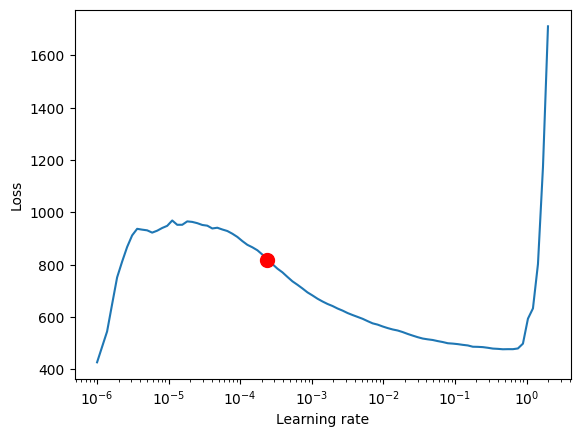

In [11]:
# Encontra a taxa de aprendizagem ideal
res = pl.tuner.Tuner(trainer).lr_find(
    modelo_tft,
    train_dataloaders=dl_treino,
    val_dataloaders=dl_valid,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
trainer.fit(modelo_tft, train_dataloaders=dl_treino, val_dataloaders=dl_valid)

# Carregar o melhor modelo salvo pelo checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# Escolha um índice válido para visualizar uma amostra específica
idx = 0

# Gera previsões com base no conjunto de validação
raw_predictions, x, _, _, _ = best_model.predict(dl_valid, mode="raw", return_x=True)

# Faz o plot usando o método interno do modelo
fig = best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
fig.show()

In [ ]:
def previsao_tft(training_df, validation_df, test_df, i, max_epochs=6):
    """
    Treina o modelo TFT e faz previsões para um conjunto de teste.

    Parâmetros:
        - training_df (DataFrame): Dados de treino.
        - validation_df (DataFrame): Dados de validação.
        - test_df (DataFrame): Dados de teste.
        - i (int): Índice da rodada de validação cruzada.
        - max_epochs (int): Número máximo de épocas de treinamento.

    Retorna:
        - test_df com as previsões adicionadas.
    """
    val_idx = validation_df["time_idx"].min()
    test_idx = test_df["time_idx"].min()

    quantis = [0.1, 0.5, 0.9]

    dados_treino = TimeSeriesDataSet(
        training_df,
        time_idx="time_idx",
        target="sales",
        group_ids=["series_id"],
        min_encoder_length=168 // 2,
        max_encoder_length=168,
        static_categoricals=["series_id"],
        min_prediction_length=1,
        max_prediction_length=28,
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["sales"],
    )

    validation_data = TimeSeriesDataSet.from_dataset(
        dados_treino,
        pd.concat([training_df, validation_df]).reset_index(drop=True),
        min_prediction_idx=val_idx,
        predict=True,
        stop_randomization=True,
    )

    test_data = TimeSeriesDataSet.from_dataset(
        dados_treino,
        pd.concat([training_df, validation_df, test_df]).reset_index(drop=True),
        min_prediction_idx=test_idx,
        predict=True,
        stop_randomization=True,
    )

    # Criando DataLoaders
    dl_treino = dados_treino.to_dataloader(
        train=True, batch_size=32, num_workers=2, pin_memory=True
    )
    dl_valid = validation_data.to_dataloader(
        train=False, batch_size=32, num_workers=2, pin_memory=True
    )
    dl_teste = test_data.to_dataloader(
        train=False, batch_size=32, num_workers=2, pin_memory=True
    )

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        gradient_clip_val=0.1,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=5, mode="min"),
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1),
        ],
        logger=TensorBoardLogger("../reports/lightning_logs", name=f"tft_cv_fold_{i}"),
    )

    modelo_tft = TemporalFusionTransformer.from_dataset(
        dados_treino,
        learning_rate=0.00023,
        hidden_size=128,
        dropout=0.1,
        loss=QuantileLoss(quantis),
    )

    trainer.fit(
        modelo_tft,
        train_dataloaders=dl_treino,
        val_dataloaders=dl_valid,
    )
    # Carregar o melhor modelo salvo durante o treinamento
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    # Fazer previsões com o modelo treinado
    predictions, _, index, _, _ = best_model.predict(dl_teste, return_index=True)

    # Criar DataFrame com previsões
    time_idx_start = index.loc[0, "time_idx"]
    time_idx_end = time_idx_start + len(predictions[0])

    predictions_df_wide = pd.DataFrame(
        predictions.cpu().numpy(), columns=range(time_idx_start, time_idx_end)
    )
    predictions_df_wide["series_id"] = index["series_id"]
    predictions_df = predictions_df_wide.melt(id_vars=["series_id"])
    predictions_df.rename(columns={"variable": "time_idx", "value": "tft_pred"}, inplace=True)

    # Fazer merge com test_df
    test_df_previsto = test_df.merge(predictions_df, on=["series_id", "time_idx"], how="left")

    return test_df_previsto

In [14]:
import os
# Criar diretório para salvar o modelo final
model_dir = "../models/"

In [15]:
# Lista de métodos de previsão e seus respectivos nomes de coluna no DataFrame
metodos_previsao = [
    (previsao_tft, "tft_pred"),
]

cv = 3
max_epochs = 20
resultados_tft = []

for metodo, nome_previsto in metodos_previsao:
    wmae_lista = []
    wmape_lista = []

    # Inicializa o modelo uma única vez antes do CV
    modelo_tft_final = None

    for i in range(cv):
        training_df, validation_df, test_df = expanding_window_split(
            df_sales_processed_transformer, i, validation=True
        )

        test_df_previsto, modelo_tft = metodo(training_df, validation_df, test_df, i, max_epochs)

        # Armazena o modelo treinado na última iteração
        modelo_tft_final = modelo_tft
        wmae, wmape = calcular_wmae_wmape(training_df, test_df_previsto, "sales", nome_previsto)

        wmae_lista.append(wmae)
        wmape_lista.append(wmape)

    # Salvar o modelo final completo (depois do CV)
    if modelo_tft_final:
        final_model_path = os.path.join(model_dir, f"{nome_previsto}_final_model.pth")
        torch.save(modelo_tft_final.state_dict(), final_model_path)
        print(f"Modelo final salvo em: {final_model_path}")

    # Armazena os resultados em uma lista
    resultados_tft.append(
        {
            "Modelo": nome_previsto,
            "WMAE - Média CV": np.mean(wmae_lista),
            "WMAE - Desvio Padrão CV": np.std(wmae_lista),
            "WMAPE - Média CV": np.mean(wmape_lista),
            "WMAPE - Desvio Padrão CV": np.std(wmape_lista),
        }
    )

# Criando DataFrame com os resultados de ambos os métodos
df_resultados_tft = pd.DataFrame(resultados_tft)

# Exibir os resultados formatados
# df_resultados_geral = pd.concat([df_resultados_geral, df_resultados_tft])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 330    | train
3  | prescalers                         | ModuleDict                      | 48     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.6 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.5 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.1 K  | train
7  | static_cont

Epoch 9: 100%|██████████| 1672/1672 [02:30<00:00, 11.10it/s, v_num=11, train_loss_step=167.0, val_loss=286.0, train_loss_epoch=165.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 330    | train
3  | prescalers                         | ModuleDict                      | 48     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.6 K  | train
5  | encoder_variable_selection         

Epoch 5: 100%|██████████| 1620/1620 [02:25<00:00, 11.10it/s, v_num=3, train_loss_step=188.0, val_loss=331.0, train_loss_epoch=172.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 330    | train
3  | prescalers                         | ModuleDict                      | 48     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.6 K  | train
5  | encoder_variable_selection         

Epoch 8: 100%|██████████| 1567/1567 [02:23<00:00, 10.89it/s, v_num=2, train_loss_step=156.0, val_loss=370.0, train_loss_epoch=157.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Modelo final salvo em: ../models/tft_pred_final_model.pth


In [16]:
df_resultados_tft

,Modelo,WMAE - Média CV,WMAE - Desvio Padrão CV,WMAPE - Média CV,WMAPE - Desvio Padrão CV
0,tft_pred,543.051025,3.419763,0.098488,0.007961


In [ ]:
df_resultados_geral

O nosso modelo **TFT (Temporal Fusion Transformer)** apresentou um desempenho ainda melhor em comparação com o **LSTM**, mostrando uma capacidade superior de capturar padrões sazonais e tendências de forma mais eficiente. Embora o **LSTM** tenha superado o **Prophet**, reduzindo significativamente os erros ao aprender padrões não lineares e dependências de longo prazo, o **TFT** conseguiu ir além, combinando a flexibilidade das redes neurais com interpretabilidade aprimorada.  

Isso se deve ao fato de que o **TFT** utiliza mecanismos avançados, como **atenção multi-head** e **redes LSTM**, permitindo modelar séries temporais tanto **univariadas quanto multivariadas**, além de atribuir pesos às variáveis mais relevantes para a previsão. Essa abordagem melhora a qualidade das previsões, tornando o modelo mais robusto e adaptável a diferentes cenários.  

Diante desse resultado, o **TFT** se torna nossa melhor opção para avançarmos no projeto. Agora, seguimos para a próxima etapa: **a otimização dos hiperparâmetros**, garantindo que o modelo alcance seu desempenho máximo e forneça previsões ainda mais precisas.